In [ ]:
pip install alpha_vantage

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from scipy.stats import zscore
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')


***Importing Live Datasets***

In [ ]:
stock = yf.Ticker("AAPL")

df = stock.history(period="5d", interval="30m")
print(df.head(50))

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-04-07 09:30:00-04:00  177.000000  181.139999  174.619995  180.490005   
2025-04-07 10:00:00-04:00  180.490005  194.139999  179.100006  181.770004   
2025-04-07 10:30:00-04:00  181.679993  185.939804  179.630005  183.869995   
2025-04-07 11:00:00-04:00  183.880005  185.179993  175.699997  176.360001   
2025-04-07 11:30:00-04:00  176.410004  180.330002  176.380005  178.779999   
2025-04-07 12:00:00-04:00  178.779999  178.841293  175.750000  178.139999   
2025-04-07 12:30:00-04:00  178.100006  179.800003  177.229996  177.600006   
2025-04-07 13:00:00-04:00  177.612503  181.720001  177.100006  181.539993   
2025-04-07 13:30:00-04:00  181.554993  182.940399  179.960007  182.600006   
2025-04-07 14:00:00-04:00  182.639999  183.889999  179.500000  180.335007   
2025-04-07 14:30:00-04:00  180.339996  182.300003  179.449997  179.970001   

***Describe***

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_5,EMA_5
count,65.000000,65.000000,65.000000,65.000000,6.500000e+01,65.0,65.0,61.000000,65.000000
mean,185.652968,188.268175,183.950434,186.112717,8.885538e+06,0.0,0.0,185.886876,185.582645
std,7.231797,7.380051,7.501161,7.507807,6.057478e+06,0.0,0.0,6.878591,6.601580
min,172.179001,173.440002,169.210098,172.770004,2.619570e+06,0.0,0.0,174.614001,174.635237
25%,179.149994,181.139999,177.750000,179.589996,5.204929e+06,0.0,0.0,180.028702,179.693447
50%,186.179993,189.229996,184.059998,186.199997,6.899078e+06,0.0,0.0,186.417999,185.032503
75%,190.789993,194.139999,189.020004,191.759995,1.022384e+07,0.0,0.0,190.893579,190.622254
max,198.490005,200.610001,197.541397,198.850006,3.845150e+07,0.0,0.0,197.948398,197.717358


In [ ]:
df['Close'].mean()

np.float64(186.1127171443059)

In [ ]:
df['Close'].median()

186.1999969482422

In [ ]:
df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()


In [ ]:
df[['Open', 'High', 'Low', 'Close', 'Volume']].cov()

,Open,High,Low,Close,Volume
Open,5.229889e+01,49.022573,5.301737e+01,4.984340e+01,-1.080484e+07
High,4.902257e+01,54.465155,5.124275e+01,5.333552e+01,-9.128266e+05
Low,5.301737e+01,51.242755,5.626742e+01,5.386644e+01,-1.138585e+07
Close,4.984340e+01,53.335515,5.386644e+01,5.636716e+01,-3.597197e+06
Volume,-1.080484e+07,-912826.595636,-1.138585e+07,-3.597197e+06,3.669304e+13


***Basic Visualization To Confirm The Trend***

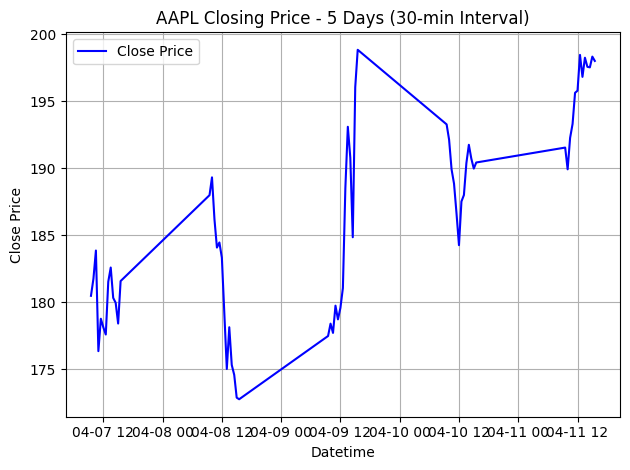

In [ ]:
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.title('AAPL Closing Price - 5 Days (30-min Interval)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


***Box Plot***

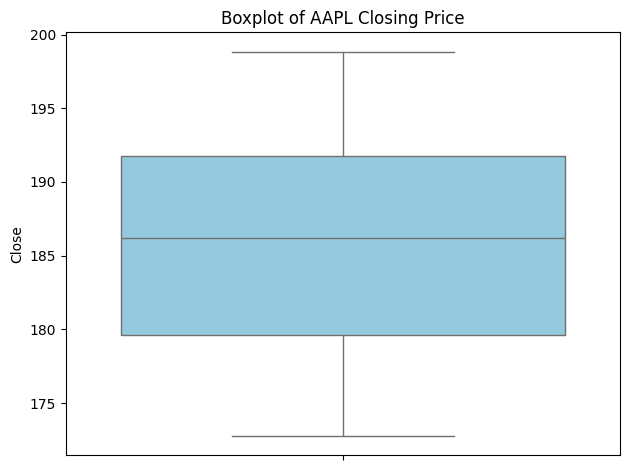

In [ ]:
sns.boxplot(data=df['Close'], color='skyblue')
plt.title("Boxplot of AAPL Closing Price")
plt.tight_layout()
plt.show()


***Histogram***

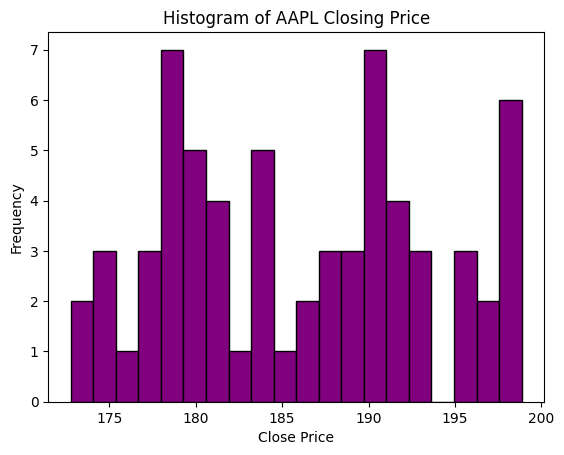

In [ ]:
plt.hist(df['Close'], bins=20, color='purple', edgecolor='black')
plt.title("Histogram of AAPL Closing Price")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()


***Bar Plot***

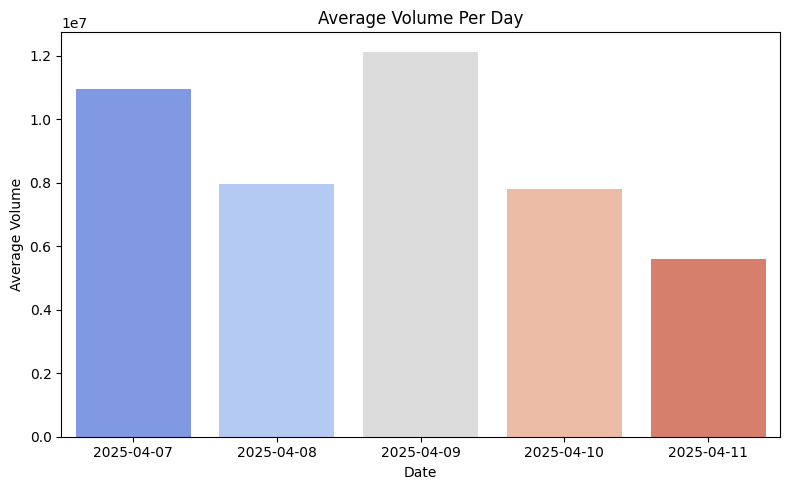

In [ ]:
df['Date'] = df.index.date

avg_volume = df.groupby('Date')['Volume'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Date', y='Volume', data=avg_volume, palette='coolwarm')
plt.title("Average Volume Per Day")
plt.xlabel("Date")
plt.ylabel("Average Volume")
plt.tight_layout()
plt.show()


***Candlestick Chart (using Plotly)***

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(title='AAPL Candlestick Chart - Last 5 Days',
                  xaxis_title='DateTime',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)
fig.show()


***Moving Averages (SMA/EMA)***

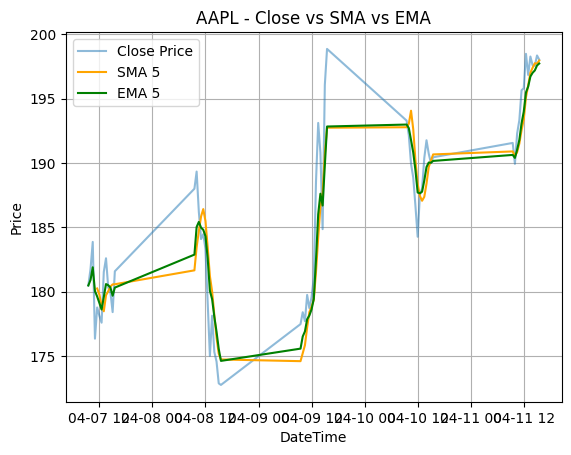

In [ ]:
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()

plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['SMA_5'], label='SMA 5', color='orange')
plt.plot(df['EMA_5'], label='EMA 5', color='green')
plt.title('AAPL - Close vs SMA vs EMA')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


***Line Plot for all Prices Movement***

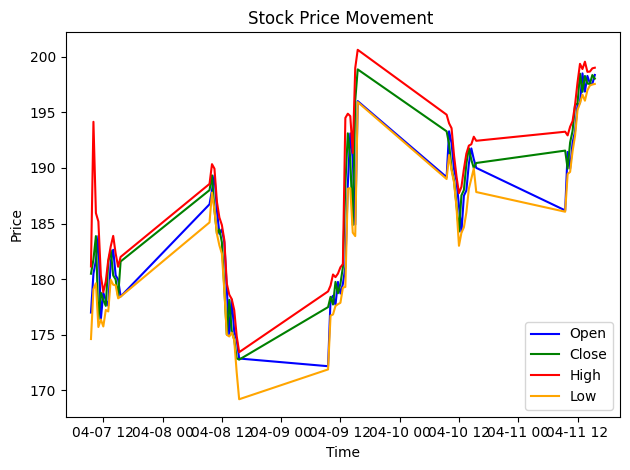

In [ ]:
plt.plot(df.index, df['Open'], label='Open', color='blue')
plt.plot(df.index, df['Close'], label='Close', color='green')
plt.plot(df.index, df['High'], label='High', color='red')
plt.plot(df.index, df['Low'], label='Low', color='orange')
plt.title("Stock Price Movement ")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


***Correlation Heatmap (e.g., Close vs Volume)***

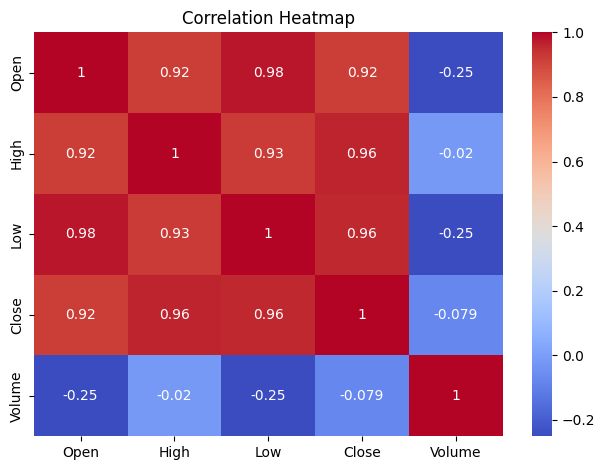

In [ ]:
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


***Data Preprocessing + Train-Test Split***



In [ ]:
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

X = df[features]
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


MSE: 0.8276709808822154
RMSE: 0.909764244671231
R² Score: 0.9834724159203927


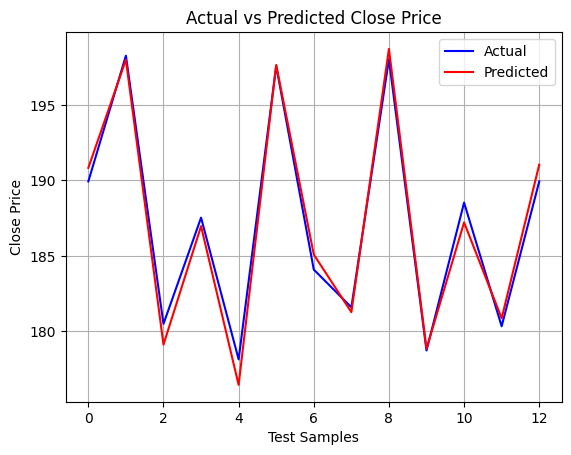

In [ ]:
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Test Samples")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


In [ ]:
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)


In [ ]:
print("Explained variance ratio for each component:", pca.explained_variance_ratio_)
print("Total variance explained:", np.sum(pca.explained_variance_ratio_))


Explained variance ratio for each component: [0.73209915 0.24747699]
Total variance explained: 0.9795761405105772


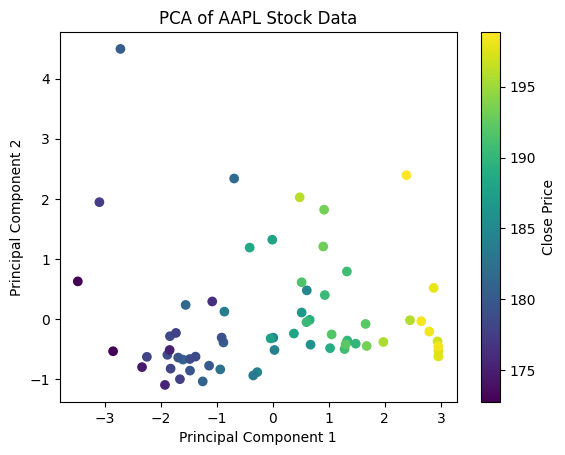

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title('PCA of AAPL Stock Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Close Price')
plt.show()


In [ ]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

lr_model_pca = LinearRegression()
lr_model_pca.fit(X_train_pca, y_train)

y_pred_pca = lr_model_pca.predict(X_test_pca)

mse_pca = mean_squared_error(y_test, y_pred_pca)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print("MSE (PCA):", mse_pca)
print("RMSE (PCA):", rmse_pca)
print("R² Score (PCA):", r2_pca)


MSE (PCA): 1.9434461179841247
RMSE (PCA): 1.3940753630934466
R² Score (PCA): 0.9611917418139613
